# Hourly Time Series Forecasting using  XGBoost

# Data

Pulling the `bp` which has data from 2015-2022 

In [48]:
# !pip install xgboost
# !pip install pystan==2.17.1 (安裝fbprophet前要先裝)
# !pip install fbprophet

In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight') # For plots

In [50]:
df = pd.read_excel('/Users/kao_oak/Desktop/Python/VS_Data/elder_bp.xlsx',index_col=[0], parse_dates=True) # We set the index column and know it has dates

df

,bp
time,
2022-03-06 09:33:00,115.0
2022-03-05 16:00:00,NaN
2022-03-05 09:36:00,108.0
2022-03-05 09:36:00,108.0
2022-03-04 16:00:00,NaN
...,...
2015-01-20 12:14:00,126.0
2015-01-20 12:14:00,126.0
2015-01-19 11:20:00,130.0


In [51]:
# remove NaN
df1 = df.dropna(axis=0, how='any')
df1

,bp
time,
2022-03-06 09:33:00,115.0
2022-03-05 09:36:00,108.0
2022-03-05 09:36:00,108.0
2022-03-04 09:56:00,146.0
2022-03-04 09:56:00,146.0
...,...
2015-01-20 12:14:00,126.0
2015-01-20 12:14:00,126.0
2015-01-19 11:20:00,130.0


# EDA

We will creat some time series features to see how the trends are impacted by day of week, hour, time of year, etc.

<AxesSubplot:title={'center':'bp'}, xlabel='time'>

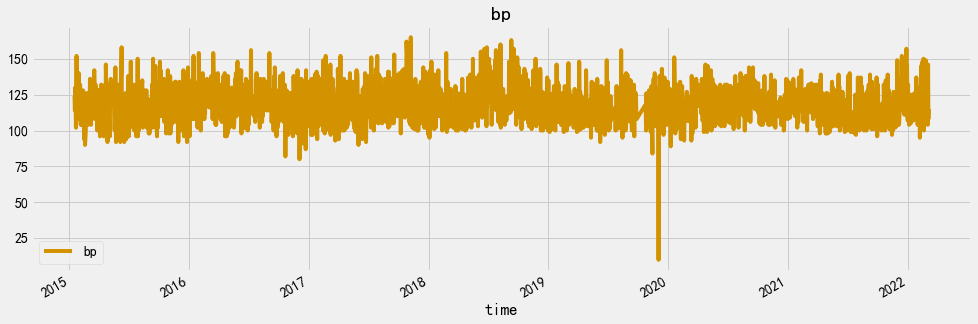

In [98]:
color_pal = ["#F8766D", "#D39200", "#93AA00", "#00BA38", "#00C19F", "#00B9E3", "#619CFF", "#DB72FB"]

# pandas.DataFrame.plot( )繪圖函数
df1.plot(y='bp',style='-', figsize=(15,5), color=color_pal[1], title='bp')

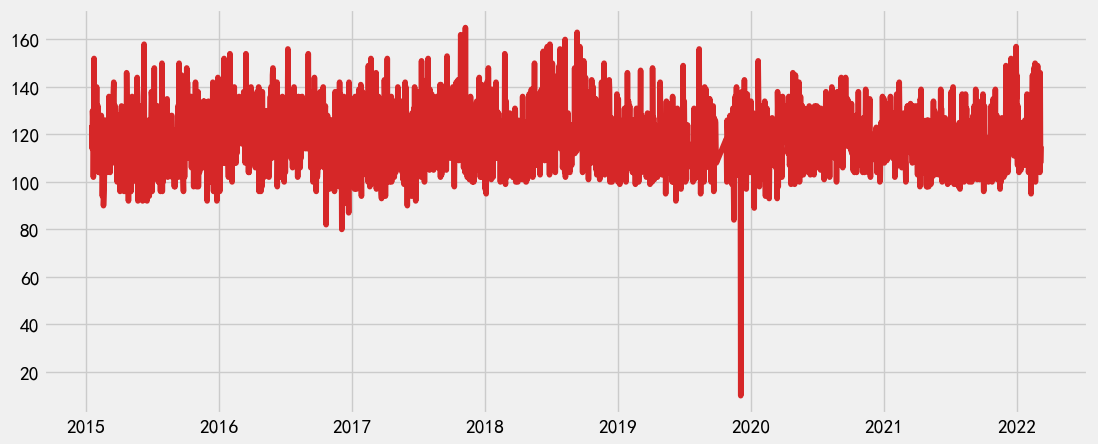

In [99]:
# time = pd.to_datetime(df1.index) # 2022-03-06 09:33:00
# plt 繪圖
plt.figure(figsize=(12, 5), dpi=100)
# plt.xlabel = df1.index
# plt.ylabel = 'bp'
plt.plot(df1.index, df1.bp, color='tab:red')
plt.show()

In [54]:
def create_features(df, label=None):
    """
    Creates time series features from datetime index
    """
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df1, label='bp')

features_and_target = pd.concat([X, y], axis=1)


<ipython-input-54-e6bedd82c3a5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df.index
<ipython-input-54-e6bedd82c3a5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['hour'] = df['date'].dt.hour
<ipython-input-54-e6bedd82c3a5>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retu

## Plotting the Features to see trends
- Power demand has strong daily and seasonal properties.
- Day of week also seems to show differences in peaks

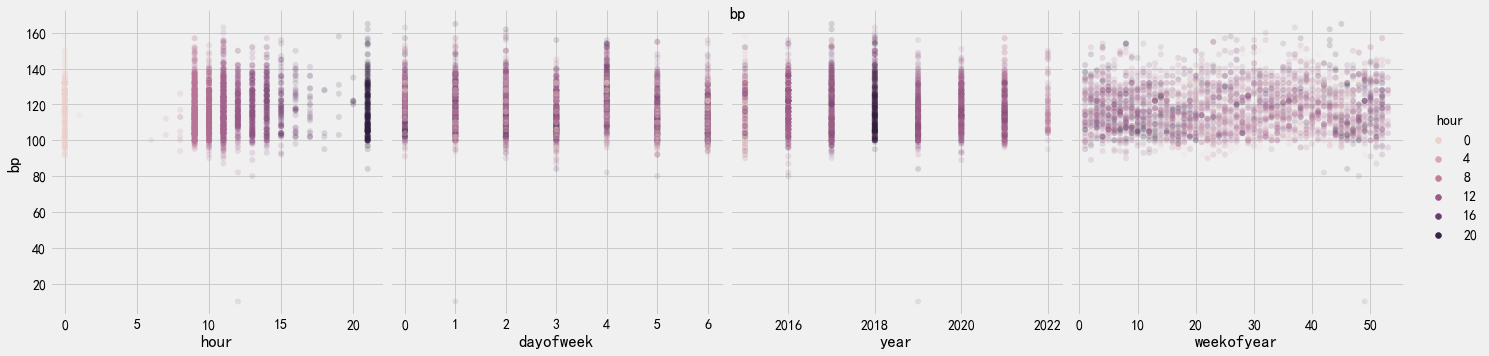

In [55]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars='bp',
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('bp')
plt.show()

# Model 1 : XGBoost


## Train/Test Split
Cut off the data after 2020 to use as our validation set. We will train on earlier data.

In [56]:
split_date = '2020-06-01'
df1_train = df1.loc[df1.index <= split_date].copy()
df1_test = df1.loc[df1.index > split_date].copy()
print(df1_train.head()) #2103
print(df1_test.head()) #700

                        bp                date  hour  dayofweek  quarter  \
time                                                                       
2020-05-31 09:01:00  106.0 2020-05-31 09:01:00     9          6        2   
2020-05-30 12:23:00  111.0 2020-05-30 12:23:00    12          5        2   
2020-05-29 09:07:00  121.0 2020-05-29 09:07:00     9          4        2   
2020-05-28 13:50:00  105.0 2020-05-28 13:50:00    13          3        2   
2020-05-27 21:00:00  128.0 2020-05-27 21:00:00    21          2        2   

                     month  year  dayofyear  dayofmonth  weekofyear  
time                                                                 
2020-05-31 09:01:00      5  2020        152          31          22  
2020-05-30 12:23:00      5  2020        151          30          22  
2020-05-29 09:07:00      5  2020        150          29          22  
2020-05-28 13:50:00      5  2020        149          28          22  
2020-05-27 21:00:00      5  2020        148    

In [57]:
X_train, y_train = create_features(df1_train, label='bp')
X_test, y_test = create_features(df1_test, label='bp')

<ipython-input-54-e6bedd82c3a5>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear
<ipython-input-54-e6bedd82c3a5>:13: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated. Please use Series.dt.isocalendar().week instead.
  df['weekofyear'] = df['date'].dt.weekofyear


## Create XGBoost Model

In [58]:
reg = xgb.XGBRegressor(n_estimators=1000)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        early_stopping_rounds=50,
       verbose=False) # Change verbose to True if you want to see it train

/opt/miniconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

## Forecast on Test Set

In [59]:
# df1_test

In [60]:
df1_test['bp_Prediction'] = reg.predict(X_test)
df1_all = pd.concat([df1_test, df1_train], sort=False)

In [61]:
df1_all.dropna()

,bp,date,hour,dayofweek,quarter,month,year,dayofyear,dayofmonth,weekofyear,bp_Prediction
time,,,,,,,,,,,
2022-03-06 09:33:00,115.0,2022-03-06 09:33:00,9,6,1,3,2022,65,6,9,115.239258
2022-03-05 09:36:00,108.0,2022-03-05 09:36:00,9,5,1,3,2022,64,5,9,113.825920
2022-03-05 09:36:00,108.0,2022-03-05 09:36:00,9,5,1,3,2022,64,5,9,113.825920
2022-03-04 09:56:00,146.0,2022-03-04 09:56:00,9,4,1,3,2022,63,4,9,119.140091
2022-03-04 09:56:00,146.0,2022-03-04 09:56:00,9,4,1,3,2022,63,4,9,119.140091
...,...,...,...,...,...,...,...,...,...,...,...
2020-06-05 09:06:00,126.0,2020-06-05 09:06:00,9,4,2,6,2020,157,5,23,117.803902
2020-06-04 10:01:00,113.0,2020-06-04 10:01:00,10,3,2,6,2020,156,4,23,109.948341
2020-06-03 14:05:00,130.0,2020-06-03 14:05:00,14,2,2,6,2020,155,3,23,112.247421


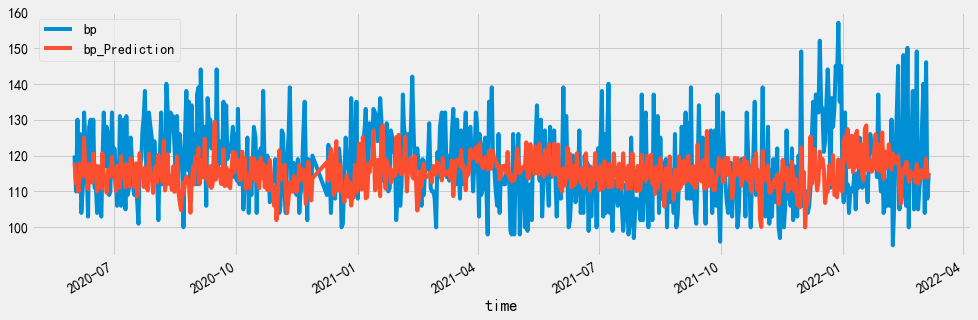

In [62]:
_ = df1_all[['bp','bp_Prediction']].dropna().plot(figsize=(15, 5))

## Look at first month of predictions

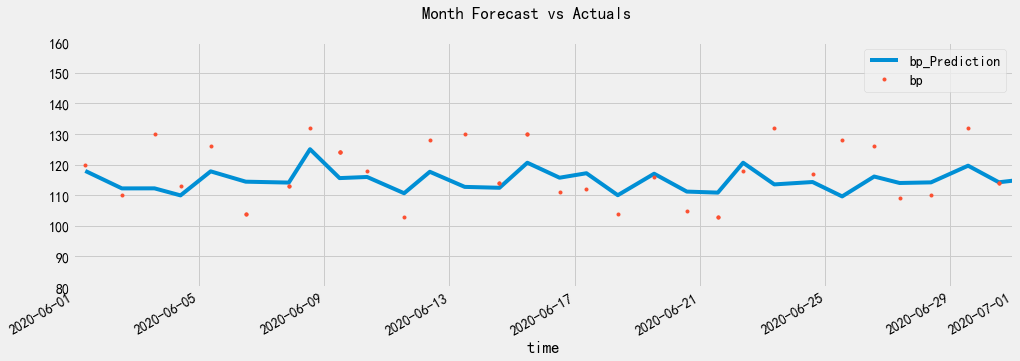

In [63]:
# Plot the forecast with the actuals (month)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df1_all[['bp_Prediction','bp']].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='06-01-2020', upper='07-01-2020')
ax.set_ylim(80, 160)
plot = plt.suptitle('Month Forecast vs Actuals')

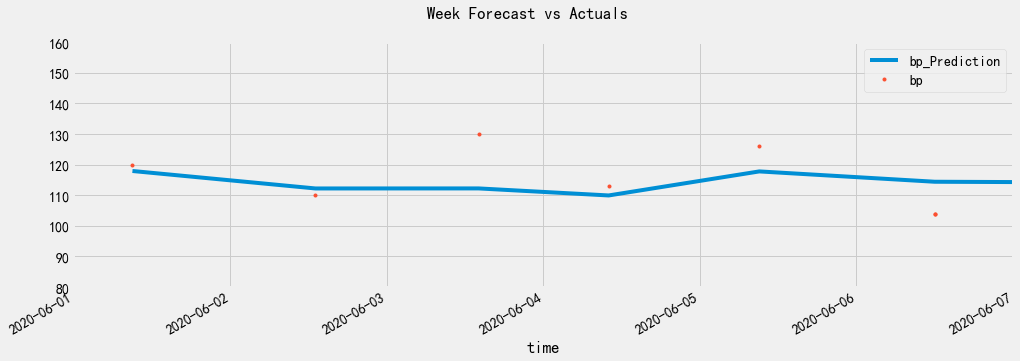

In [64]:
# Plot the forecast with the actuals (week)
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(15)
_ = df1_all[['bp_Prediction','bp']].plot(ax=ax,style=['-','.'])
ax.set_xbound(lower='06-01-2020', upper='06-07-2020')
ax.set_ylim(80, 160)
plot = plt.suptitle('Week Forecast vs Actuals')

## Error Metrics On Test Set

In [65]:
# RMSE error 

mean_squared_error(y_true=df1_test['bp'],
                   y_pred=df1_test['bp_Prediction']) # 137.8

137.86239923445964

In [66]:
# MAE error
mean_absolute_error(y_true=df1_test['bp'],
                   y_pred=df1_test['bp_Prediction']) # 9.2

9.217498245239257

In [67]:
# MAPE isn't included in sklearn so we need to use a custom function.
def mean_absolute_percentage_error(y_true, y_pred): 
    """Calculates MAPE given y_true and y_pred"""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

mean_absolute_percentage_error(y_true=df1_test['bp'],  y_pred=df1_test['bp_Prediction'])   # 7.60

7.6859843715621805

## Look at Worst and Best Predicted Days

In [84]:
df1_test['error'] = df1_test['bp'] - df1_test['bp_Prediction']
df1_test['abs_error'] = df1_test['error'].apply(np.abs)
error_by_day = df1_test.groupby(['year','month','dayofmonth','dayofweek','hour']) \
    .mean()[['bp','bp_Prediction','error','abs_error']]

error_by_day

bp  bp_Prediction      error  \
year month dayofmonth dayofweek hour                                    
2020 6     1          0         9     120.0     117.942474   2.057526   
           2          1         13    110.0     112.232872  -2.232872   
           3          2         14    130.0     112.247421  17.752579   
           4          3         10    113.0     109.948341   3.051659   
           5          4         9     126.0     117.803902   8.196098   
...                                     ...            ...        ...   
2022 3     2          2         9     140.0     115.838181  24.161819   
           3          3         9     104.0     114.034370 -10.034370   
           4          4         9     146.0     119.140091  26.859909   
           5          5         9     108.0     113.825920  -5.825920   
           6          6         9     115.0     115.239258  -0.239258   

                                      abs_error  
year month dayofmonth dayofweek hour             
2020 6     1          0         9      2.057526  
           2          1         13     2.232872  
           3          2         14    17.752579  
           4          3         10     3.051659  
           5          4         9      8.196098  
...                                         ...  
2022 3     2          2         9     24.161819  
           3          3         9     10.034370  
           4          4         9     26.859909  
           5          5         9      5.825920  
           6          6         9      0.239258  

[637 rows x 4 columns]

In [85]:
# Over forecasted days
error_by_day.sort_values(['error','year','month','dayofmonth','dayofweek','hour'], ascending=True).head(20)

bp  bp_Prediction      error  \
year month dayofmonth dayofweek hour                                    
2022 2     7          0         9      95.0     120.564468 -25.564468   
2021 1     29         4         12    102.0     125.128288 -23.128288   
     7     19         0         9      99.0     120.618355 -21.618355   
2022 1     10         0         9     105.0     125.801003 -20.801003   
2021 9     30         3         9      96.0     116.500107 -20.500107   
     10    13         2         9     100.0     119.258232 -19.258232   
     7     23         4         9      98.0     117.217583 -19.217583   
     6     9          2         9     102.0     120.443260 -18.443260   
2020 8     3          0         11    102.0     120.228958 -18.228958   
2021 4     8          3         9      98.0     116.187347 -18.187347   
           1          3         21    103.0     120.973038 -17.973038   
2020 12    11         4         9     104.0     121.875313 -17.875313   
     11    2          0         12    104.0     121.464333 -17.464333   
2021 5     24         0         9     106.0     123.234283 -17.234283   
           2          6         13     98.0     115.063004 -17.063004   
2022 1     1          5         9     107.0     123.826180 -16.826180   
2021 6     23         2         9      99.0     115.515701 -16.515701   
     7     27         1         9      97.0     113.502998 -16.502998   
     5     6          3         9     100.0     116.445457 -16.445457   
     4     25         6         11     99.0     115.083565 -16.083565   

                                      abs_error  
year month dayofmonth dayofweek hour             
2022 2     7          0         9     25.564468  
2021 1     29         4         12    23.128288  
     7     19         0         9     21.618355  
2022 1     10         0         9     20.801003  
2021 9     30         3         9     20.500107  
     10    13         2         9     19.258232  
     7     23         4         9     19.217583  
     6     9          2         9     18.443260  
2020 8     3          0         11    18.228958  
2021 4     8          3         9     18.187347  
           1          3         21    17.973038  
2020 12    11         4         9     17.875313  
     11    2          0         12    17.464333  
2021 5     24         0         9     17.234283  
           2          6         13    17.063004  
2022 1     1          5         9     16.826180  
2021 6     23         2         9     16.515701  
     7     27         1         9     16.502998  
     5     6          3         9     16.445457  
     4     25         6         11    16.083565

In [95]:
# Worst absolute predicted days
error_by_day.sort_values(['abs_error','year','month','dayofmonth','dayofweek','hour'], ascending=False).head(30)

bp  bp_Prediction      error  \
year month dayofmonth dayofweek hour                                    
2021 12    28         1         9     157.0     118.929092  38.070908   
           26         6         9     145.0     108.998138  36.001862   
           30         3         9     145.0     110.355896  34.644104   
           20         0         9     144.0     109.835861  34.164139   
           27         0         9     142.0     108.360970  33.639030   
2022 2     18         4         9     150.0     117.733826  32.266174   
           15         1         9     148.0     116.527321  31.472679   
           25         4         9     149.0     117.629097  31.370903   
2021 12    14         1         9     152.0     121.103462  30.896538   
2020 12    26         5         15    136.0     106.057411  29.942589   
2021 7     8          3         9     140.0     111.116364  28.883636   
     2     10         2         14    142.0     114.227760  27.772240   
     1     17         6         11    136.0     108.681808  27.318192   
2020 8     9          6         12    140.0     112.868805  27.131195   
2021 7     3          5         9     138.0     111.125656  26.874344   
2022 3     4          4         9     146.0     119.140091  26.859909   
2021 11    30         1         9     149.0     122.277328  26.722672   
2020 9     16         2         9     144.0     117.375885  26.624115   
     11    10         1         11    139.0     112.575844  26.424156   
2021 12    12         6         9     136.0     110.306496  25.693504   
2022 2     7          0         9      95.0     120.564468 -25.564468   
2020 9     4          4         9     144.0     118.631897  25.368103   
     12    30         2         14    135.0     109.712753  25.287247   
2021 12    19         6         9     135.0     109.893585  25.106415   
2022 2     11         4         9     145.0     119.902367  25.097633   
2021 1     6          2         14    133.0     108.106087  24.893913   
     3     13         5         12    133.0     108.699539  24.300461   
2022 3     2          2         9     140.0     115.838181  24.161819   
2021 12    23         3         9     136.0     111.943947  24.056053   
           25         5         9     133.0     108.998138  24.001862   

                                      abs_error  
year month dayofmonth dayofweek hour             
2021 12    28         1         9     38.070908  
           26         6         9     36.001862  
           30         3         9     34.644104  
           20         0         9     34.164139  
           27         0         9     33.639030  
2022 2     18         4         9     32.266174  
           15         1         9     31.472679  
           25         4         9     31.370903  
2021 12    14         1         9     30.896538  
2020 12    26         5         15    29.942589  
2021 7     8          3         9     28.883636  
     2     10         2         14    27.772240  
     1     17         6         11    27.318192  
2020 8     9          6         12    27.131195  
2021 7     3          5         9     26.874344  
2022 3     4          4         9     26.859909  
2021 11    30         1         9     26.722672  
2020 9     16         2         9     26.624115  
     11    10         1         11    26.424156  
2021 12    12         6         9     25.693504  
2022 2     7          0         9     25.564468  
2020 9     4          4         9     25.368103  
     12    30         2         14    25.287247  
2021 12    19         6         9     25.106415  
2022 2     11         4         9     25.097633  
2021 1     6          2         14    24.893913  
     3     13         5         12    24.300461  
2022 3     2          2         9     24.161819  
2021 12    23         3         9     24.056053  
           25         5         9     24.001862

In [94]:
# Best absolute predicted days
error_by_day.sort_values(['abs_error','year','month','dayofmonth','dayofweek','hour'], ascending=True).head(30)

bp  bp_Prediction     error  \
year month dayofmonth dayofweek hour                                   
2020 8     30         6         9     112.0     111.999649  0.000351   
2021 4     22         3         12    115.0     115.016586 -0.016586   
     9     10         4         9     117.0     116.970642  0.029358   
     5     13         3         13    115.0     114.952034  0.047966   
2020 10    5          0         12    121.0     121.053352 -0.053352   
2021 8     31         1         9     111.0     110.946533  0.053467   
2020 12    12         5         15    115.0     114.945000  0.055000   
2021 8     25         2         9     113.0     113.055672 -0.055672   
2022 2     28         0         9     116.0     115.892937  0.107063   
2020 9     3          3         9     112.0     112.133194 -0.133194   
     6     30         1         13    114.0     114.234627 -0.234627   
2022 3     6          6         9     115.0     115.239258 -0.239258   
2021 1     21         3         14    111.0     110.755096  0.244904   
     2     5          4         9     125.0     125.253746 -0.253746   
     4     24         5         14    114.0     113.695709  0.304291   
     10    18         0         9     119.0     119.330772 -0.330772   
2020 7     12         6         9     111.0     111.336014 -0.336014   
2021 6     5          5         11    112.0     111.659546  0.340454   
     3     27         5         11    120.0     119.641006  0.358994   
2020 8     18         1         9     110.0     110.365791 -0.365791   
     12    25         4         15    113.0     112.622948  0.377052   
2021 7     17         5         9     113.0     113.382027 -0.382027   
2020 9     14         0         21    129.0     129.385315 -0.385315   
2021 10    12         1         9     115.0     114.573601  0.426399   
     8     18         2         9     114.0     113.470154  0.529846   
     10    1          4         9     119.0     118.439255  0.560745   
     4     29         3         12    116.0     115.438309  0.561691   
     6     1          1         9     112.0     111.396950  0.603050   
     10    15         4         9     117.0     117.603172 -0.603172   
     1     7          3         13    109.0     108.370949  0.629051   

                                      abs_error  
year month dayofmonth dayofweek hour             
2020 8     30         6         9      0.000351  
2021 4     22         3         12     0.016586  
     9     10         4         9      0.029358  
     5     13         3         13     0.047966  
2020 10    5          0         12     0.053352  
2021 8     31         1         9      0.053467  
2020 12    12         5         15     0.055000  
2021 8     25         2         9      0.055672  
2022 2     28         0         9      0.107063  
2020 9     3          3         9      0.133194  
     6     30         1         13     0.234627  
2022 3     6          6         9      0.239258  
2021 1     21         3         14     0.244904  
     2     5          4         9      0.253746  
     4     24         5         14     0.304291  
     10    18         0         9      0.330772  
2020 7     12         6         9      0.336014  
2021 6     5          5         11     0.340454  
     3     27         5         11     0.358994  
2020 8     18         1         9      0.365791  
     12    25         4         15     0.377052  
2021 7     17         5         9      0.382027  
2020 9     14         0         21     0.385315  
2021 10    12         1         9      0.426399  
     8     18         2         9      0.529846  
     10    1          4         9      0.560745  
     4     29         3         12     0.561691  
     6     1          1         9      0.603050  
     10    15         4         9      0.603172  
     1     7          3         13     0.629051

## Plotting some best/worst predicted days

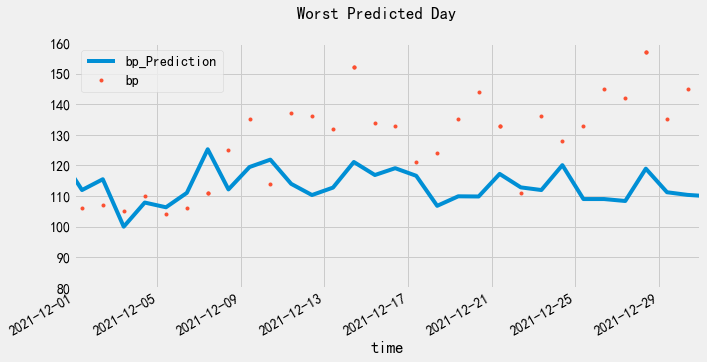

In [92]:
# Worst absolute predicted days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df1_all[['bp_Prediction','bp']].plot(ax=ax, style=['-','.'])
ax.set_ylim(80, 160)
ax.set_xbound(lower='12-1-2021', upper='12-31-2021')
plot = plt.suptitle('Worst Predicted Day')

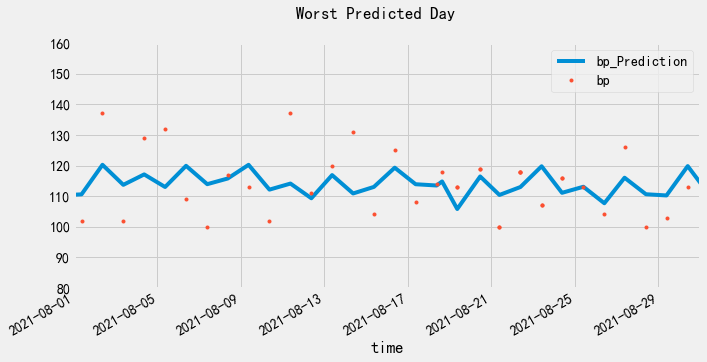

In [93]:
# Best absolute predicted days
f, ax = plt.subplots(1)
f.set_figheight(5)
f.set_figwidth(10)
_ = df1_all[['bp_Prediction','bp']].plot(ax=ax, style=['-','.'])
ax.set_ylim(80, 160)
ax.set_xbound(lower='08-1-2021', upper='08-31-2021')
plot = plt.suptitle('Worst Predicted Day')